<a href="https://colab.research.google.com/github/nikitagrygoriev/Kinect/blob/master/OurDataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data

###Mounting Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

###Loading data from Drive

In [0]:
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat


cwd = os.getcwd()
cwd = os.path.join(cwd,'drive/My Drive/ProcessedData')

data = {}

folders = os.listdir(cwd)
for fruit in folders:
    records = []
    for record in os.listdir(os.path.join(cwd,fruit)):
        records.append(loadmat(os.path.join(cwd,fruit,record)))
    data[fruit] = records

In [3]:
print(data['Banana'][0]['vals'][:1])

[[[-1.26653463e-01 -1.83449358e-01  7.91000009e-01  2.55000000e+02
    2.55000000e+02  2.55000000e+02]
  [-1.26653463e-01 -1.83449358e-01  7.91000009e-01  2.55000000e+02
    2.55000000e+02  2.55000000e+02]
  [-1.24351025e-01 -1.83225185e-01  7.90000021e-01  2.55000000e+02
    2.55000000e+02  2.55000000e+02]
  ...
  [ 2.39752516e-01 -1.77710652e-01  7.68000007e-01  2.55000000e+02
    2.55000000e+02  2.55000000e+02]
  [ 2.39752516e-01 -1.77710652e-01  7.68000007e-01  2.55000000e+02
    2.55000000e+02  2.55000000e+02]
  [ 2.39752516e-01 -1.77710652e-01  7.68000007e-01  2.55000000e+02
    2.55000000e+02  2.55000000e+02]]]


###Creating train and test sets

In [0]:
X,y = [],[]
for fruit_name in data:
    for fruit_sample in data[fruit_name]:
        X.append(fruit_sample['vals'])
        y.append(fruit_name)

In [5]:
y = np.asarray(y)
X = np.asarray(X)
print(y.shape)
print(X.shape)

(500,)
(500, 500, 500, 6)


In [0]:
X_new = X[:,:,:,[3,4,5,0,1,2]]

In [0]:
X_normalised = X_new[:,:,:,:3] / 255 

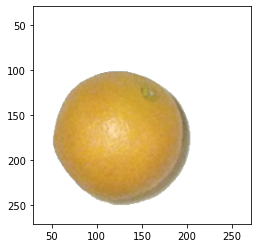

In [8]:
import matplotlib.pyplot as plt


plt.imshow(X_normalised[229,100:401,100:401,:3])
plt.margins(x=-.1, y=-.1)
plt.show()


###Encoding

In [0]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
y = le.fit_transform(y)

y = to_categorical(y)

###Normalizing

In [0]:
X_new[:,:,:,3:5] += 1
X_new[:,:,:,:3] /= 255
X_new[:,:,:,3] /= np.amax(X_new[:,:,:,3])
X_new[:,:,:,4] /= np.amax(X_new[:,:,:,4])
X_new[:,:,:,5] /= np.amax(X_new[:,:,:,5])

###Splitting

In [11]:
from sklearn.model_selection import train_test_split as split

X_train, X_test, y_train, y_test = split(X_new, y, test_size=.3)
X_train, X_val, y_train, y_val = split(X_train, y_train, test_size=0.3)
print(len(X_train))
print(len(X_val))
print(len(X_test))
print()
print(len(y_train))
print(len(y_val))
print(len(y_test))

245
105
150

245
105
150


#RGB Model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

model = Sequential()
model.add(Conv2D(20, 2, activation='relu', input_shape=(500,500,3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(30, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
#optimizer=SGD(learning_rate=0.01, momentum=.7, nesterov=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 499, 499, 20)      260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 30)      2430      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 30)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 30)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115320)            0         
_________________________________________________________________
dense (Dense)                (None, 48)                5

In [14]:
hist = model.fit(X_train[:,:,:,:3], y_train, batch_size=40, epochs=15, validation_data=(X_val[:,:,:,:3], y_val))

Epoch 1/15
7/7 [==============================] - 5s 766ms/step - loss: 16.7750 - accuracy: 0.1796 - val_loss: 7.0108 - val_accuracy: 0.1810
Epoch 2/15
7/7 [==============================] - 5s 735ms/step - loss: 3.9677 - accuracy: 0.2367 - val_loss: 2.3125 - val_accuracy: 0.1810
Epoch 3/15
7/7 [==============================] - 5s 714ms/step - loss: 1.7687 - accuracy: 0.3265 - val_loss: 1.5434 - val_accuracy: 0.2000
Epoch 4/15
7/7 [==============================] - 5s 723ms/step - loss: 1.6549 - accuracy: 0.2163 - val_loss: 1.4528 - val_accuracy: 0.2286
Epoch 5/15
7/7 [==============================] - 5s 718ms/step - loss: 1.3746 - accuracy: 0.4367 - val_loss: 1.5454 - val_accuracy: 0.3905
Epoch 6/15
7/7 [==============================] - 5s 744ms/step - loss: 1.3583 - accuracy: 0.5020 - val_loss: 1.2536 - val_accuracy: 0.6762
Epoch 7/15
7/7 [==============================] - 5s 721ms/step - loss: 1.1983 - accuracy: 0.5388 - val_loss: 1.4551 - val_accuracy: 0.5333
Epoch 8/15
7/7 [===

#RGB Model Accuracy (0.73)

In [15]:
model.evaluate(X_test[:,:,:,:3], y_test)[1]

5/5 [==============================] - 0s 89ms/step - loss: 0.7418 - accuracy: 0.7267


0.7266666889190674

#RGB + Kinect Model

In [16]:
modelK = Sequential()
modelK.add(Conv2D(20, 2, activation='relu', input_shape=(500,500,6)))
modelK.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
modelK.add(Conv2D(30, 2, activation='relu'))
modelK.add(MaxPooling2D(pool_size=(2, 2)))
modelK.add(MaxPooling2D(pool_size=(2, 2)))
modelK.add(Flatten())
modelK.add(Dense(48, activation='relu'))
modelK.add(Dense(16, activation='relu'))
modelK.add(Dense(5, activation='softmax'))
modelK.compile(loss='categorical_crossentropy', metrics=['accuracy'])
modelK.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 499, 499, 20)      500       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 249, 249, 20)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 248, 248, 30)      2430      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 124, 124, 30)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115320)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)               

In [17]:
hist = modelK.fit(X_train, y_train, batch_size=40, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
7/7 [==============================] - 6s 795ms/step - loss: 2.6358 - accuracy: 0.2327 - val_loss: 1.4998 - val_accuracy: 0.4286
Epoch 2/15
7/7 [==============================] - 5s 781ms/step - loss: 1.6716 - accuracy: 0.4367 - val_loss: 1.4573 - val_accuracy: 0.2571
Epoch 3/15
7/7 [==============================] - 6s 799ms/step - loss: 1.7421 - accuracy: 0.4163 - val_loss: 1.1602 - val_accuracy: 0.4190
Epoch 4/15
7/7 [==============================] - 6s 800ms/step - loss: 1.0177 - accuracy: 0.5388 - val_loss: 2.9124 - val_accuracy: 0.4000
Epoch 5/15
7/7 [==============================] - 6s 787ms/step - loss: 1.4299 - accuracy: 0.5224 - val_loss: 1.0747 - val_accuracy: 0.4667
Epoch 6/15
7/7 [==============================] - 5s 774ms/step - loss: 0.7843 - accuracy: 0.7347 - val_loss: 0.6576 - val_accuracy: 0.8095
Epoch 7/15
7/7 [==============================] - 5s 732ms/step - loss: 0.5981 - accuracy: 0.7878 - val_loss: 0.7858 - val_accuracy: 0.6952
Epoch 8/15
7/7 [====

#RGB + Kinect Model Accuracy (0.74)

In [18]:
modelK.evaluate(X_test, y_test)[1]

5/5 [==============================] - 0s 84ms/step - loss: 0.4095 - accuracy: 0.7400


0.7400000095367432

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(245, 500, 500, 6)
(105, 500, 500, 6)
(150, 500, 500, 6)


In [23]:
modelXYZ = Sequential()
modelXYZ.add(Conv2D(20, 2, activation='relu', input_shape=(500,500,3)))
modelXYZ.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
modelXYZ.add(Conv2D(30, 2, activation='relu'))
modelXYZ.add(MaxPooling2D(pool_size=(2, 2)))
modelXYZ.add(MaxPooling2D(pool_size=(2, 2)))
modelXYZ.add(Flatten())
modelXYZ.add(Dense(48, activation='relu'))
modelXYZ.add(Dense(16, activation='relu'))
modelXYZ.add(Dense(5, activation='softmax'))
modelXYZ.compile(loss='categorical_crossentropy', metrics=['accuracy'])
modelXYZ.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 499, 499, 20)      260       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 249, 20)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 248, 248, 30)      2430      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 124, 124, 30)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 30)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 115320)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 48)               

#Kinect Only Model

In [24]:
hist = modelXYZ.fit(X_train[:,:,:,3:], y_train, batch_size=40, epochs=15, validation_data=(X_val[:,:,:,3:], y_val))

Epoch 1/15
7/7 [==============================] - 5s 728ms/step - loss: 17.2646 - accuracy: 0.2000 - val_loss: 2.5834 - val_accuracy: 0.1810
Epoch 2/15
7/7 [==============================] - 5s 707ms/step - loss: 2.0571 - accuracy: 0.1918 - val_loss: 2.3606 - val_accuracy: 0.1810
Epoch 3/15
7/7 [==============================] - 5s 693ms/step - loss: 1.7927 - accuracy: 0.1959 - val_loss: 2.0370 - val_accuracy: 0.1810
Epoch 4/15
7/7 [==============================] - 5s 692ms/step - loss: 1.7593 - accuracy: 0.2122 - val_loss: 1.7408 - val_accuracy: 0.1810
Epoch 5/15
7/7 [==============================] - 5s 695ms/step - loss: 1.6438 - accuracy: 0.2163 - val_loss: 1.8676 - val_accuracy: 0.2476
Epoch 6/15
7/7 [==============================] - 5s 713ms/step - loss: 1.7081 - accuracy: 0.1673 - val_loss: 1.6743 - val_accuracy: 0.1810
Epoch 7/15
7/7 [==============================] - 5s 680ms/step - loss: 1.6288 - accuracy: 0.1592 - val_loss: 1.7249 - val_accuracy: 0.1810
Epoch 8/15
7/7 [===

#Kinect Only Model Accuracy (0.22)

In [25]:
model.evaluate(X_test[:,:,:,3:], y_test)[1]

5/5 [==============================] - 0s 86ms/step - loss: 3.7769 - accuracy: 0.2200


0.2199999988079071

#Saving Models

In [26]:
model.save('modelRGB')
modelK.save('modelRGBXYZ')
modelXYZ.save('modelXYZ')

INFO:tensorflow:Assets written to: modelRGB/assets
INFO:tensorflow:Assets written to: modelRGBXYZ/assets
INFO:tensorflow:Assets written to: modelXYZ/assets
